# Author : 
    Sahlaoui Ayoub


# Importation

In [2]:
from cassandra.cluster import Cluster
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import uuid
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
import numpy as np
import xgboost as xgb
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb

# Connect to Cassandra Cluster

In [12]:
cluster = Cluster(['127.0.0.1'], port=9042)
session = cluster.connect()
print("Connected to Cassandra!")


Connected to Cassandra!


# Drop Keyspace if it exists

In [162]:
keyspace_drop_query = "DROP KEYSPACE IF EXISTS credit_card_fraud;"
session.execute(keyspace_drop_query)
print("Keyspace 'credit_card_fraud' dropped if it existed.")

Keyspace 'credit_card_fraud' dropped if it existed.


# Create Keyspace

In [ ]:
keyspace_creation_query = """
CREATE KEYSPACE IF NOT EXISTS credit_card_fraud
WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '1'};
"""
session.execute(keyspace_creation_query)
print("Keyspace 'credit_card_fraud' created.")

Keyspace 'credit_card_fraud' created.


# Use the Keyspace

In [13]:
session.set_keyspace('credit_card_fraud')
print("Switched to keyspace 'credit_card_fraud'.")

Switched to keyspace 'credit_card_fraud'.


# Create UDT for Features


In [165]:
udt_creation_query = """
CREATE TYPE IF NOT EXISTS feature_set (
    v1 FLOAT,
    v2 FLOAT,
    v3 FLOAT,
    v4 FLOAT,
    v5 FLOAT,
    v6 FLOAT,
    v7 FLOAT,
    v8 FLOAT,
    v9 FLOAT,
    v10 FLOAT,
    v11 FLOAT,
    v12 FLOAT,
    v13 FLOAT,
    v14 FLOAT,
    v15 FLOAT,
    v16 FLOAT,
    v17 FLOAT,
    v18 FLOAT,
    v19 FLOAT,
    v20 FLOAT,
    v21 FLOAT,
    v22 FLOAT,
    v23 FLOAT,
    v24 FLOAT,
    v25 FLOAT,
    v26 FLOAT,
    v27 FLOAT,
    v28 FLOAT
);
"""
session.execute(udt_creation_query)
print("UDT 'feature_set' created.")

UDT 'feature_set' created.


# Create Table


In [166]:
table_creation_query = """
CREATE TABLE IF NOT EXISTS transactions (
    id UUID PRIMARY KEY,
    time INT,
    amount FLOAT,
    features feature_set,
    label INT
);
"""
session.execute(table_creation_query)
print("Table 'transactions' created with UUID as the primary key.")

Table 'transactions' created with UUID as the primary key.


# Load the Dataset

In [167]:
df = pd.read_csv('creditcard.csv')  

# Prepare the INSERT query

In [168]:
insert_query = """
INSERT INTO transactions (id, time, amount, features, label)
VALUES (%s, %s, %s, {v1: %s, v2: %s, v3: %s, v4: %s, v5: %s, v6: %s, v7: %s, v8: %s, 
                     v9: %s, v10: %s, v11: %s, v12: %s, v13: %s, v14: %s, v15: %s, v16: %s, 
                     v17: %s, v18: %s, v19: %s, v20: %s, v21: %s, v22: %s, v23: %s, 
                     v24: %s, v25: %s, v26: %s, v27: %s, v28: %s}, %s);
"""

# Insert rows into the table

In [169]:
for _, row in df.iterrows():
    row_uuid = uuid.uuid4()  # Generate a unique UUID for each row
    session.execute(
        insert_query,
        (
            row_uuid,  # Generated UUID
            int(row["Time"]),
            float(row["Amount"]),
            float(row["V1"]), float(row["V2"]), float(row["V3"]), float(row["V4"]),
            float(row["V5"]), float(row["V6"]), float(row["V7"]), float(row["V8"]),
            float(row["V9"]), float(row["V10"]), float(row["V11"]), float(row["V12"]),
            float(row["V13"]), float(row["V14"]), float(row["V15"]), float(row["V16"]),
            float(row["V17"]), float(row["V18"]), float(row["V19"]), float(row["V20"]),
            float(row["V21"]), float(row["V22"]), float(row["V23"]), float(row["V24"]),
            float(row["V25"]), float(row["V26"]), float(row["V27"]), float(row["V28"]),
            int(row["Class"]),
        ),
    )
print("Dataset inserted")

Dataset inserted


# Visualizing Data

In [73]:
# Query to retrieve data from the transactions table
query = "SELECT * FROM transactions where Time = 312 limit 1 allow filtering ;"
rows = session.execute(query)

# Print the results in a readable and well-organized format
print("Retrieved Transactions:")
print("=" * 60)

for row in rows:
    print(f"Time       : {row.time}")
    print(f"Amount     : {row.amount}")
    print("Features   :")
    
    # Iterate over features and exclude unwanted attributes
    for feature in dir(row.features):
        if feature not in ['count', 'index'] and not feature.startswith('_'):
            value = getattr(row.features, feature)
            print(f"    {feature:<6}: {value}")
    
    print(f"Label      : {row.label}")
    print("=" * 60)


Retrieved Transactions:
Time       : 312
Amount     : 493.44000244140625
Features   :
    v1    : 0.23098106682300568
    v10   : -0.7018494009971619
    v11   : -0.6825742721557617
    v12   : 0.316230833530426
    v13   : -0.6448338031768799
    v14   : -0.2808169722557068
    v15   : 0.08534280955791473
    v16   : -0.3166560232639313
    v17   : 0.47668254375457764
    v18   : -0.904761016368866
    v19   : -0.043026190251111984
    v2    : -2.0004830360412598
    v20   : 0.8341792225837708
    v21   : 0.07966921478509903
    v22   : -0.6103784441947937
    v23   : -0.3091284930706024
    v24   : 0.16702429950237274
    v25   : -0.13772812485694885
    v26   : 0.9224212765693665
    v27   : -0.11335336416959763
    v28   : 0.09396933019161224
    v3    : 0.5551548004150391
    v4    : 0.600645899772644
    v5    : -1.5510236024856567
    v6    : 0.24233293533325195
    v7    : -0.13318295776844025
    v8    : 0.10598410665988922
    v9    : 1.248545527458191
Label      : 0


# class distribution

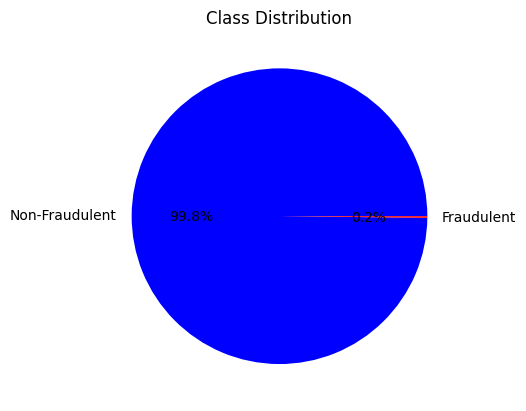

In [16]:
# Query to retrieve data from the transactions table
query = "SELECT * FROM transactions;"
rows = session.execute(query)
data = []
for row in rows:
    features = [getattr(row.features, f'v{i+1}') for i in range(28)]
    data.append([row.id, row.time, row.amount, *features, row.label])

columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']
df = pd.DataFrame(data, columns=columns)

# Calculate class distribution
class_counts = df['label'].value_counts()

# Plot the class distribution as a pie chart
class_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Non-Fraudulent', 'Fraudulent'], colors=['blue', 'red'])

# Customize the plot
plt.title('Class Distribution')
plt.ylabel('')  # Removes the default y-label for better visualization
plt.show()



## Addressing Imbalanced Data 

When working with fraud detection, the dataset is often imbalanced, with far more non-fraudulent transactions than fraudulent ones. This imbalance makes it difficult for machine learning models to learn patterns related to fraud, as they tend to focus on the majority class (non-fraudulent transactions). To tackle this issue, we use a technique called **SMOTE** (Synthetic Minority Oversampling Technique).

### Why Use SMOTE?

SMOTE helps balance the dataset by generating synthetic samples for the minority class (fraudulent transactions). Instead of simply duplicating existing data points, SMOTE creates new samples by interpolating between existing ones. This makes the dataset more balanced and provides the model with more opportunities to learn about the minority class.

### How Does SMOTE Work?

Here’s how SMOTE generates new samples:
1. **Choose a Minority Sample**: It starts by selecting a random sample from the minority class.
2. **Find Nearest Neighbors**: It identifies similar samples (neighbors) within the minority class based on feature similarity.
3. **Create Synthetic Samples**: New samples are generated by combining the selected sample with its neighbors, effectively filling in gaps in the minority class distribution.


# PCA 

### Feature Selection

The dataset we are working with has already undergone **Principal Component Analysis (PCA)**. PCA is a dimensionality reduction technique that transforms the original features into a smaller set of uncorrelated components, capturing most of the variance in the data. This preprocessing step simplifies the dataset and helps the model focus on the most important patterns.

### Why Revisit Feature Selection?

Even though PCA was applied, we revisit the feature selection process for the following reasons:
- **Improved Model Interpretability**: While PCA creates uncorrelated components, they are linear combinations of the original features, making them less interpretable. Selecting specific features from the original dataset can provide clearer insights into what drives fraud detection.
- **Enhancing Model Performance**: Not all PCA components may contribute equally to the task at hand. Some components might add noise or irrelevant information, which could negatively impact the model's ability to detect fraud.
- **Customized Feature Engineering**: By performing feature selection, we ensure that our model uses the most relevant and meaningful components for this specific use case.

### How Feature Selection Was Done

We applied feature selection methods after analyzing the dataset and assessing the contribution of each PCA component to the model’s performance. This approach allowed us to fine-tune the inputs for the model and ensure it learns from the most relevant features.

By combining PCA’s ability to reduce dimensionality with selective feature inclusion, we aim to strike a balance between model simplicity and predictive power. This step ensures that our model not only performs well but also remains interpretable and robust.


### Set page size for batch retrieval

In [19]:
session.default_fetch_size = 10000 

### Initialize Incremental PCA


In [20]:
n_components = 28  # Number of components to retain
ipca = IncrementalPCA(n_components=n_components)

### Query for all data

In [21]:
query = "SELECT id, time, amount, features, label FROM transactions;"

### Fetch the first page

In [22]:
result_set = session.execute(query)

### Prepare data from the first page

In [23]:
rows = result_set.current_rows
first_page_data = []
for row in rows:
    features = [getattr(row.features, f'v{i+1}') for i in range(28)]
    first_page_data.append([row.id, row.time, row.amount, *features, row.label])

### Create a DataFrame for easier manipulation

In [24]:
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']
df_first_page = pd.DataFrame(first_page_data, columns=columns)

### Convert to numpy array (only numeric columns)


In [25]:
numeric_data_first_page = df_first_page.iloc[:, 3:-1].to_numpy()  # Skip non-numeric columns

### Explained variance for the first batch

In [26]:
ipca.partial_fit(numeric_data_first_page)


IncrementalPCA(n_components=28)

### Fit Incremental PCA on the first batch


In [27]:
explained_variance_ratio_first_batch = ipca.explained_variance_ratio_
cumulative_variance_first_batch = np.cumsum(explained_variance_ratio_first_batch)

### Display results for the first batch


In [28]:
print("Explained Variance Ratio (First Batch):", explained_variance_ratio_first_batch)
print("Cumulative Explained Variance (First Batch):", cumulative_variance_first_batch)


Explained Variance Ratio (First Batch): [0.12655804 0.0887723  0.07309326 0.06796893 0.06102173 0.05673214
 0.04557604 0.04262646 0.04064682 0.03672221 0.03473865 0.03380113
 0.03296427 0.02972953 0.02808841 0.02600108 0.02387613 0.02308726
 0.02056989 0.01988956 0.01808608 0.01617798 0.0135786  0.01274074
 0.00931173 0.00788174 0.00550918 0.0042501 ]
Cumulative Explained Variance (First Batch): [0.12655804 0.21533034 0.2884236  0.35639253 0.41741427 0.47414641
 0.51972245 0.56234891 0.60299574 0.63971795 0.6744566  0.70825772
 0.74122199 0.77095152 0.79903993 0.825041   0.84891713 0.87200439
 0.89257428 0.91246384 0.93054992 0.9467279  0.9603065  0.97304725
 0.98235898 0.99024072 0.9957499  1.        ]


### Process remaining batches


In [77]:
total_data_processed = len(df_first_page)
paging_state = result_set.paging_state  # Save the initial paging state

while paging_state:
    # Fetch the next page using the paging state
    result_set = session.execute(query, paging_state=paging_state)
    rows = result_set.current_rows
    paging_state = result_set.paging_state  # Update the paging state for the next iteration

    # Extract data from the page
    page_data = []
    for row in rows:
        features = [getattr(row.features, f'v{i+1}') for i in range(28)]
        page_data.append([row.id, row.time, row.amount, *features, row.label])
    
    df_page = pd.DataFrame(page_data, columns=columns)
    
    # Convert to numpy array (only numeric columns)
    numeric_data_page = df_page.iloc[:, 3:-1].to_numpy()
    
    # Incrementally fit the PCA model
    ipca.partial_fit(numeric_data_page)
    total_data_processed += len(df_page)
print(f" {total_data_processed} Processed")


 150000 Processed


### Final Explained Variance Ratios


In [72]:
final_explained_variance_ratio = ipca.explained_variance_ratio_
final_cumulative_variance = np.cumsum(final_explained_variance_ratio)
print("Final Explained Variance Ratio:", final_explained_variance_ratio)
print("Final Cumulative Explained Variance:", final_cumulative_variance)

Final Explained Variance Ratio: [0.12483757 0.08872945 0.07480934 0.06523148 0.06199045 0.05775592
 0.04979852 0.04641696 0.03927497 0.03857867 0.03390148 0.03248758
 0.03223271 0.02990076 0.02726173 0.02498448 0.02347316 0.0228603
 0.02156271 0.01933907 0.01755591 0.01713671 0.01268881 0.01193577
 0.00884199 0.00756684 0.00530131 0.00354534]
Final Cumulative Explained Variance: [0.12483757 0.21356702 0.28837636 0.35360784 0.41559829 0.47335421
 0.52315273 0.56956969 0.60884466 0.64742333 0.68132481 0.71381239
 0.7460451  0.77594586 0.80320759 0.82819207 0.85166522 0.87452552
 0.89608823 0.91542731 0.93298321 0.95011992 0.96280874 0.97474451
 0.9835865  0.99115334 0.99645466 1.        ]


###  Plot results

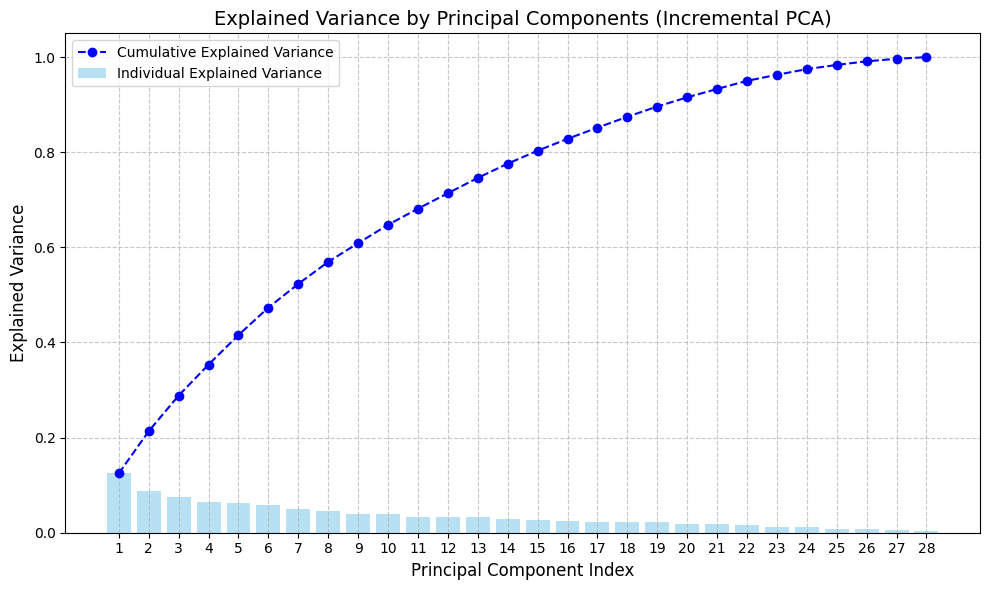

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(final_explained_variance_ratio) + 1),
    final_explained_variance_ratio,
    alpha=0.6,
    color='skyblue',
    label='Individual Explained Variance'
)
plt.plot(
    range(1, len(final_cumulative_variance) + 1),
    final_cumulative_variance,
    marker='o',
    linestyle='--',
    color='blue',
    label='Cumulative Explained Variance'
)
plt.xlabel('Principal Component Index', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)
plt.title('Explained Variance by Principal Components (Incremental PCA)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(final_explained_variance_ratio) + 1))
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Interpretation 
all the 28 components are necessary to explain the data behavior

# MODELS 

## Logistic regression 

`Logistic Regression` is a simple yet powerful statistical model used for binary classification problems. Despite its name, it is a classification algorithm, not a regression algorithm.

#### Key Features
- **Linear Model**: Predicts probabilities using a linear combination of input features.
- **Sigmoid Function**: Maps predicted values to probabilities between 0 and 1.
- **Binary Classification**: Assigns outputs to one of two classes based on a probability threshold (e.g., 0.5).

#### How It Works
1. Computes a linear combination of input features: $$ z = w_1x_1 + w_2x_2 + \ldots + w_nx_n + b $$
2. Applies the sigmoid function to compute probabilities: $$ P(y=1|x) = \frac{1}{1 + e^{-z}} $$
3. Classifies based on the probability: Class 1 if $$ P \geq 0.5 $$, else Class 0.

#### Advantages
- Easy to implement and interpret.
- Requires minimal computational resources.
- Performs well with linearly separable data.
- Provides probabilistic outputs for confidence levels.

#### Limitations
- Assumes a linear relationship between features and the log-odds of the target.
- Struggles with highly imbalanced data unless regularization or resampling techniques (e.g., SMOTE) are applied.
- Less effective for complex relationships in the data compared to non-linear models.

#### Example Use Case
Logistic regression is widely used in binary classification tasks like fraud detection, spam email detection, or medical diagnosis.



### Note: 
Cassandra excels at batching, fast retrieval, and insertion of data, making it ideal for handling large datasets in a distributed environment. 
However, Logistic Regression does not natively support incremental learning across batches. This limitation will be addressed in the following models.


### first Batch retrieval

In [33]:
session.default_fetch_size = 150000
query = "SELECT id, time, amount, features, label FROM transactions;"
result_set = session.execute(query)
rows = result_set.current_rows
first_page_data = []
for row in rows:
    features = [getattr(row.features, f'v{i+1}') for i in range(28)]
    first_page_data.append([row.id, row.time, row.amount, *features, row.label])
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']
df_first_page = pd.DataFrame(first_page_data, columns=columns)

In [34]:
X_first_page = df_first_page.drop(columns=['id', 'time', 'label']).values
y_first_page = df_first_page['label'].values

### Train a Logistic Regression model

In [35]:
logistic_regression_model = LogisticRegression(random_state=42 , max_iter = 300000)
logistic_regression_model.fit(X_first_page, y_first_page)

LogisticRegression(max_iter=300000, random_state=42)

### Predict and evaluate

In [36]:
y_pred_first_page = logistic_regression_model.predict(X_first_page)

### Create the confusion matrix

In [37]:
logistic_regression_cm = confusion_matrix(y_first_page, y_pred_first_page)

### Plot the confusion matrix as a heatmap


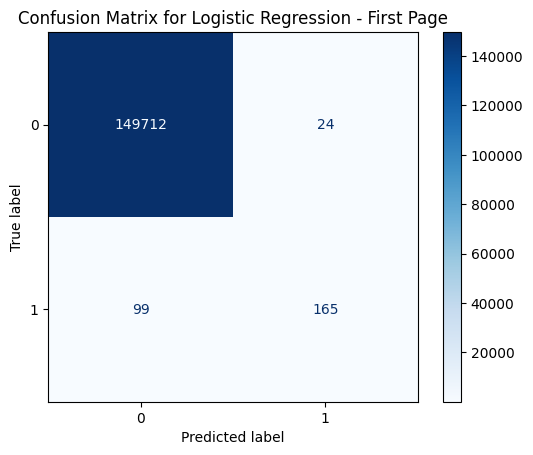

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=logistic_regression_cm, display_labels=logistic_regression_model.classes_)
disp.plot(cmap="Blues", values_format="d")  # Customize colormap and format if needed
plt.title("Confusion Matrix for Logistic Regression - First Page")
plt.show()

### Print the classification report for additional metrics


In [40]:
print("Classification Report for First Page:")
print(classification_report(y_first_page, y_pred_first_page))

Classification Report for First Page:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149736
           1       0.87      0.62      0.73       264

    accuracy                           1.00    150000
   macro avg       0.94      0.81      0.86    150000
weighted avg       1.00      1.00      1.00    150000



### Applying smote to oversample minority class

In [41]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_first_page, y_first_page)

### Check the new class distribution after SMOTE


In [42]:
unique, counts = np.unique(y_smote, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique, counts)))

Class distribution after SMOTE: {np.int64(0): np.int64(149736), np.int64(1): np.int64(149736)}


### Fit the logistic regression model


In [43]:
smote_logistic_regression_model= LogisticRegression(random_state=42, max_iter=300000)
smote_logistic_regression_model.fit(X_smote, y_smote)

LogisticRegression(max_iter=300000, random_state=42)

### Predict on the original first page data


In [44]:
y_pred_smote_first_page = smote_logistic_regression_model.predict(X_smote)

### Confusion Matrix


In [45]:
smote_logistic_regression_cm = confusion_matrix(y_smote, y_pred_smote_first_page)
print("Confusion Matrix:")
print(smote_logistic_regression_cm)

Confusion Matrix:
[[146866   2870]
 [ 10209 139527]]


### Visualize the Confusion Matrix


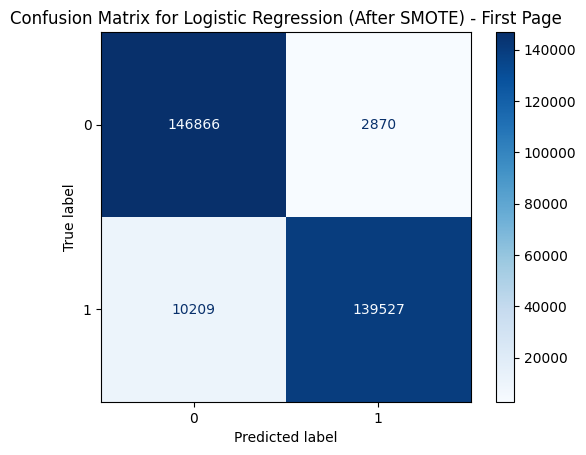

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=smote_logistic_regression_cm, display_labels=smote_logistic_regression_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Logistic Regression (After SMOTE) - First Page")
plt.show()

### Classification Report


In [47]:
print("Classification Report for First Page (After SMOTE):")
print(classification_report(y_smote, y_pred_smote_first_page))

Classification Report for First Page (After SMOTE):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    149736
           1       0.98      0.93      0.96    149736

    accuracy                           0.96    299472
   macro avg       0.96      0.96      0.96    299472
weighted avg       0.96      0.96      0.96    299472



# Incremental Training with SGDClassifier


### SGDClassifier Overview

`SGDClassifier` is a linear model in scikit-learn that uses **Stochastic Gradient Descent (SGD)** for optimization. It is highly efficient for large-scale datasets and supports **incremental learning**, making it ideal for streaming or batch-processing scenarios.

#### Key Features
- **Online Learning**: Supports `partial_fit` to train incrementally on batches of data.
- **Versatile Loss Functions**: Includes `log_loss` (logistic regression), `hinge` (SVM), and more.
- **Regularization**: Prevents overfitting with L1, L2, or elastic net regularization.
- **Scalability**: Processes data one sample or mini-batch at a time, making it memory-efficient.

#### How It Works
SGD optimizes a specified loss function (e.g., `log_loss`) by updating model weights for each sample or mini-batch using gradient estimates. This enables fast training but introduces some randomness in convergence.

#### Advantages
- Handles large datasets efficiently.
- Supports diverse loss functions and regularization techniques.
- Suitable for real-time applications with incremental updates.

#### Limitations
- Sensitive to hyperparameters like learning rate and regularization.
- Outputs are not probabilities unless `log_loss` is used.

#### Example Use Case
SGDClassifier is ideal for tasks like large-scale logistic regression or SVMs when incremental or memory-efficient training is required.


### first batch retrieval


In [85]:
session.default_fetch_size = 80000
query = "SELECT id, time, amount, features, label FROM transactions;"
result_set = session.execute(query)
rows = result_set.current_rows
first_page_data = []
for row in rows:
    features = [getattr(row.features, f'v{i+1}') for i in range(28)]
    first_page_data.append([row.id, row.time, row.amount, *features, row.label])
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']
df_first_batch = pd.DataFrame(first_page_data, columns=columns)

### Prepare features (X) and labels (y) for the first batch


In [86]:
X_first_batch = df_first_batch.drop(columns=['id', 'time', 'label']).values
y_first_batch = df_first_batch['label'].values

### Compute class weights


In [87]:
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.array([0, 1]), 
    y=y_first_batch
)
class_weights_dict = dict(enumerate(class_weights))  # Convert to dictionary

### Initialize SGDClassifier

In [88]:
SGDClassifier_model = SGDClassifier(loss='log_loss', random_state=42, class_weight=class_weights_dict)

### Train the model on the first batch


In [89]:
SGDClassifier_model.partial_fit(X_first_batch, y_first_batch, classes=np.array([0, 1]), sample_weight=None)

SGDClassifier(class_weight={0: np.float64(0.5008577188435195),
                            1: np.float64(291.97080291970804)},
              loss='log_loss', random_state=42)

### Evaluate the model on the first batch


In [90]:
# Initialize lists to collect predictions and true labels
all_y_true = []
all_y_pred = []
y_pred_first_batch = SGDClassifier_model.predict(X_first_batch)

 # Collect true labels and predictions for the current batch
all_y_true.extend(y_first_batch)
all_y_pred.extend(y_pred_first_batch)

print("Classification Report for First Batch:")
print(classification_report(y_first_batch, y_pred_first_batch))

Classification Report for First Batch:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     79863
           1       0.16      0.82      0.27       137

    accuracy                           0.99     80000
   macro avg       0.58      0.91      0.64     80000
weighted avg       1.00      0.99      0.99     80000



### Incremental Training on Subsequent Batches

In [91]:


# Start the loop for training on subsequent batches
batch_counter = 1

while result_set.has_more_pages:
    # Fetch the next page
    result_set = session.execute(query, paging_state=result_set.paging_state)
    rows = result_set.current_rows

    # Check if the current batch is empty
    if not rows:
        print(f"Batch {batch_counter} is empty. Skipping...")
        batch_counter += 1
        continue

    # Prepare the data for the current batch
    current_batch_data = []
    for row in rows:
        features = [getattr(row.features, f'v{i+1}') for i in range(28)]
        current_batch_data.append([row.id, row.time, row.amount, *features, row.label])

    # Create a DataFrame for the current batch
    df_current_batch = pd.DataFrame(current_batch_data, columns=columns)

    # Prepare features (X) and labels (y) for the current batch
    X_current_batch = df_current_batch.drop(columns=['id', 'time', 'label']).values
    y_current_batch = df_current_batch['label'].values

    # Ensure model is initialized with `classes`
    if batch_counter == 1:
        SGDClassifier_model.partial_fit(X_current_batch, y_current_batch, classes=np.array([0, 1]))
    else:
        SGDClassifier_model.partial_fit(X_current_batch, y_current_batch)

    # Evaluate the SGDClassifier_model on the current batch
    y_pred_current_batch = SGDClassifier_model.predict(X_current_batch)
    print(f"Classification Report for Batch {batch_counter} ({len(df_current_batch)} rows):")
    print(classification_report(y_current_batch, y_pred_current_batch))

    # Collect true labels and predictions for the current batch
    all_y_true.extend(y_current_batch)
    all_y_pred.extend(y_pred_current_batch)

    # Increment batch counter
    batch_counter += 1



Classification Report for Batch 1 (80000 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79857
           1       0.34      0.80      0.48       143

    accuracy                           1.00     80000
   macro avg       0.67      0.90      0.74     80000
weighted avg       1.00      1.00      1.00     80000

Classification Report for Batch 2 (80000 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79869
           1       0.44      0.81      0.57       131

    accuracy                           1.00     80000
   macro avg       0.72      0.90      0.78     80000
weighted avg       1.00      1.00      1.00     80000

Classification Report for Batch 3 (44807 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44726
           1       0.41      0.81      0.55        81

    accuracy                          

### confusion matrix SGDClassifier

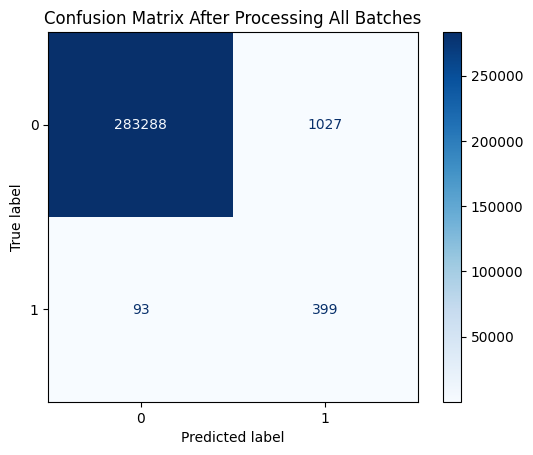

All batches processed.


In [92]:
# Ensure there are collected predictions and true labels
if all_y_true and all_y_pred:
    # Compute the confusion matrix after processing all batches
    SGDClassifier_cm = confusion_matrix(all_y_true, all_y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=SGDClassifier_cm, display_labels=SGDClassifier_model.classes_)
    disp.plot(cmap="Blues", values_format="d")  # Customize as needed
    plt.title("Confusion Matrix After Processing All Batches")
    plt.show()
else:
    print("No predictions or true labels collected. Unable to compute confusion matrix.")

print("All batches processed.")


## applying smote

In [93]:
# Define the query to fetch data
query = "SELECT id, time, amount, features, label FROM transactions;"
result_set = session.execute(query)
rows = result_set.current_rows

# Prepare the columns
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']

# Initialize SMOTE and the SGDClassifier
smote = SMOTE(random_state=42)
SGDC_smote_model  = SGDClassifier(loss='log_loss', random_state=42)

# Initialize lists to collect predictions and true labels
all_y_true = []
all_y_pred = []

# Batch training loop
batch_counter = 1

while True:
    # Fetch the next page if available
    if not rows:
        break

    # Prepare the data for the current batch
    current_batch_data = []
    for row in rows:
        features = [getattr(row.features, f'v{i+1}') for i in range(28)]
        current_batch_data.append([row.id, row.time, row.amount, *features, row.label])

    # Create a DataFrame for the current batch
    df_current_batch = pd.DataFrame(current_batch_data, columns=columns)

    # Prepare features (X) and labels (y) for the current batch
    X_current_batch = df_current_batch.drop(columns=['id', 'time', 'label']).values
    y_current_batch = df_current_batch['label'].values

    # Apply SMOTE to oversample the minority class in the current batch
    X_resampled, y_resampled = smote.fit_resample(X_current_batch, y_current_batch)

    # Incrementally train the SGDC_smote_model  using `partial_fit` on the SMOTE-resampled data
    SGDC_smote_model .partial_fit(X_resampled, y_resampled, classes=np.array([0, 1]))

    # Evaluate the SGDC_smote_model  on the resampled (balanced) data
    y_pred_resampled = SGDC_smote_model .predict(X_resampled)
    print(f"Classification Report for Batch {batch_counter} ({len(X_resampled)} rows, After SMOTE):")
    print(classification_report(y_resampled, y_pred_resampled))

    # Collect true labels and predictions for all batches
    all_y_true.extend(y_resampled)
    all_y_pred.extend(y_pred_resampled)

    # Increment batch counter
    batch_counter += 1

    # Fetch the next page
    if result_set.has_more_pages:
        result_set = session.execute(query, paging_state=result_set.paging_state)
        rows = result_set.current_rows
    else:
        break



print("All batches processed with SMOTE.")

Classification Report for Batch 1 (159726 rows, After SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     79863
           1       0.81      0.93      0.86     79863

    accuracy                           0.85    159726
   macro avg       0.86      0.85      0.85    159726
weighted avg       0.86      0.85      0.85    159726

Classification Report for Batch 2 (159714 rows, After SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     79857
           1       0.99      0.92      0.95     79857

    accuracy                           0.95    159714
   macro avg       0.96      0.95      0.95    159714
weighted avg       0.96      0.95      0.95    159714

Classification Report for Batch 3 (159738 rows, After SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     79869
           1       0.91      0.97      0.94     798

### Confusion matrix SGDClassifier after smote

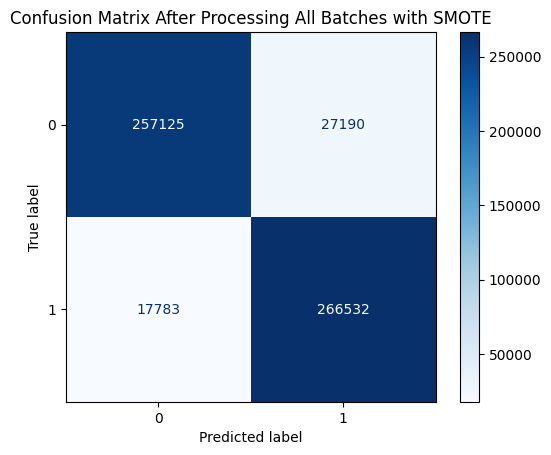

In [94]:
# Compute the confusion matrix after processing all batches
SGDClassifier_smote_cm = confusion_matrix(all_y_true, all_y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=SGDClassifier_smote_cm, display_labels=SGDC_smote_model.classes_)
disp.plot(cmap="Blues", values_format="d")  # Customize as needed
plt.title("Confusion Matrix After Processing All Batches with SMOTE")
plt.show()

# LIGHTGBM

`LightGBM` is a highly efficient and scalable gradient boosting framework designed for large-scale data processing. It uses decision tree algorithms to boost model performance and is well-suited for structured data.

#### Key Features
- **Gradient Boosting Framework**: Combines weak learners (decision trees) iteratively to minimize loss.
- **Efficient Splitting**: Uses histogram-based algorithms for faster computation and reduced memory usage.
- **Feature Importance**: Automatically ranks features based on their predictive power.

#### How It Works
- Builds decision trees sequentially, with each tree improving on the errors of the previous one.
- Optimizes a loss function (e.g., binary cross-entropy for classification) using gradient descent.
- Uses leaf-wise growth with depth constraints to improve accuracy and efficiency.

#### Advantages
- Handles large datasets with high speed.
- Supports categorical features natively.
- Offers excellent performance with default parameters.
- Works well with imbalanced datasets when tuned (`scale_pos_weight`).

#### Limitations
- May overfit if `max_depth` and `num_leaves` are not properly tuned.
- Less interpretable compared to simpler models like linear regression.

#### Example Use Case
LightGBM is ideal for tabular data in tasks such as fraud detection, recommendation systems, or any application requiring fast and accurate predictions.


### first batch retrieval

In [223]:
session.default_fetch_size = 50000  # Retrieve 80000 rows per page
query = "SELECT id, time, amount, features, label FROM transactions;"
result_set = session.execute(query)
first_batch_data = []
for row in rows:
    features = [getattr(row.features, f'v{i+1}') for i in range(28)]
    first_batch_data.append([row.id, row.time, row.amount, *features, row.label])
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']
df_first_batch = pd.DataFrame(first_batch_data, columns=columns)


### Prepare features (X) and labels (y) for the first batch


In [224]:
X_first_batch = df_first_batch.drop(columns=['id', 'time', 'label']).values
y_first_batch = df_first_batch['label'].values

### Create a LightGBM dataset


In [225]:
dtrain = lgb.Dataset(X_first_batch, label=y_first_batch)


### Set LightGBM parameters


In [226]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,       # Smaller learning rate for more stable training
    'num_leaves': 128,           # Increase leaves to allow more splits
    'max_depth': -1,             # Remove depth restrictions
    'max_bin': 511,              # Increase bins for finer splits
    'scale_pos_weight': len(y_first_batch) / sum(y_first_batch == 1),  # Handle class imbalance
    'random_state': 42,
    'verbosity': -1               
}

### Train the LightGBM model

In [227]:
num_boost_round = 1000
bst = lgb.train(params, dtrain, num_boost_round)

### Predict on the first batch


In [228]:
y_pred_first_batch = (bst.predict(X_first_batch) > 0.5).astype(int)


### Evaluate the model


In [229]:
print("Classification Report for First Batch:")
print(classification_report(y_first_batch, y_pred_first_batch))

Classification Report for First Batch:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34736
           1       1.00      1.00      1.00        71

    accuracy                           1.00     34807
   macro avg       1.00      1.00      1.00     34807
weighted avg       1.00      1.00      1.00     34807



### Incremental Training on Subsequent Batches


In [230]:
# Initialize an empty LightGBM booster for incremental training
bst = None
batch_counter = 1

# Initialize lists to collect predictions and true labels
all_y_true = []
all_y_pred = []

# Initialize total processed rows counter
total_processed_rows = 0

# Loop through batches
while True:
    # Fetch the next page if available
    if not rows:
        break

    # Prepare the data for the current batch
    current_batch_data = []
    for row in rows:
        features = [getattr(row.features, f'v{i+1}') for i in range(28)]
        current_batch_data.append([row.id, row.time, row.amount, *features, row.label])

    # Create a DataFrame for the current batch
    df_current_batch = pd.DataFrame(current_batch_data, columns=columns)

    # Prepare features (X) and labels (y) for the current batch
    X_current_batch = df_current_batch.drop(columns=['id', 'time', 'label']).values
    y_current_batch = df_current_batch['label'].values

    # Convert the current batch to a LightGBM dataset
    dtrain_current = lgb.Dataset(X_current_batch, label=y_current_batch)

    # Update the model using the new batch
    if bst is None:
        # Train the model on the first batch
        bst = lgb.train(params, dtrain_current, num_boost_round=100)
    else:
        # Continue training with the new batch
        bst = lgb.train(params, dtrain_current, num_boost_round=100, init_model=bst)

    # Evaluate the model on the current batch
    y_pred_current_batch = (bst.predict(X_current_batch) > 0.5).astype(int)
    print(f"Classification Report for Batch {batch_counter} ({len(X_current_batch)} rows):")
    print(classification_report(y_current_batch, y_pred_current_batch))

    # Collect true labels and predictions for all batches
    all_y_true.extend(y_current_batch)
    all_y_pred.extend(y_pred_current_batch)

    # Update total processed rows
    total_processed_rows += len(X_current_batch)

    # Increment batch counter
    batch_counter += 1

    # Fetch the next page
    if result_set.has_more_pages:
        result_set = session.execute(query, paging_state=result_set.paging_state)
        rows = result_set.current_rows
    else:
        break

print(f"All batches processed. Total rows processed: {total_processed_rows}")


Classification Report for Batch 1 (34807 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34736
           1       0.95      1.00      0.97        71

    accuracy                           1.00     34807
   macro avg       0.97      1.00      0.99     34807
weighted avg       1.00      1.00      1.00     34807

Classification Report for Batch 2 (50000 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49913
           1       0.78      1.00      0.87        87

    accuracy                           1.00     50000
   macro avg       0.89      1.00      0.94     50000
weighted avg       1.00      1.00      1.00     50000

Classification Report for Batch 3 (50000 rows):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49913
           1       0.62      1.00      0.76        87

    accuracy                          

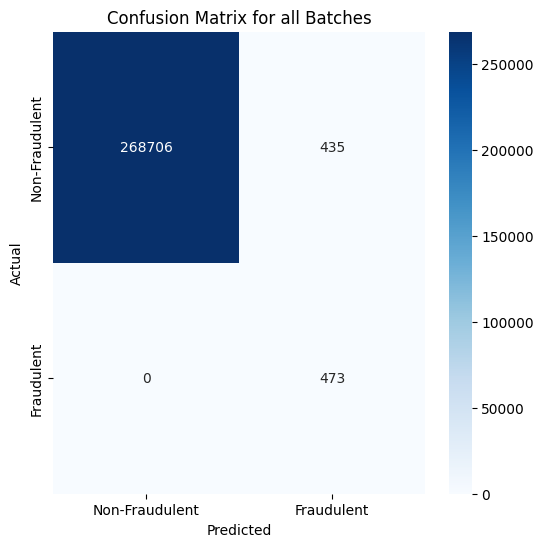

In [231]:
# Confusion Matrix
lightgbm_cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(lightgbm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraudulent', 'Fraudulent'],yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title(f'Confusion Matrix for all Batches')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### LightGBM on smote

Classification Report for Batch 1 (99820 rows, After SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     49910
           1       0.99      1.00      0.99     49910

    accuracy                           0.99     99820
   macro avg       0.99      0.99      0.99     99820
weighted avg       0.99      0.99      0.99     99820

Classification Report for Batch 2 (99826 rows, After SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49913
           1       0.98      1.00      0.99     49913

    accuracy                           0.99     99826
   macro avg       0.99      0.99      0.99     99826
weighted avg       0.99      0.99      0.99     99826

Classification Report for Batch 3 (99826 rows, After SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49913
           1       0.98      1.00      0.99     49913


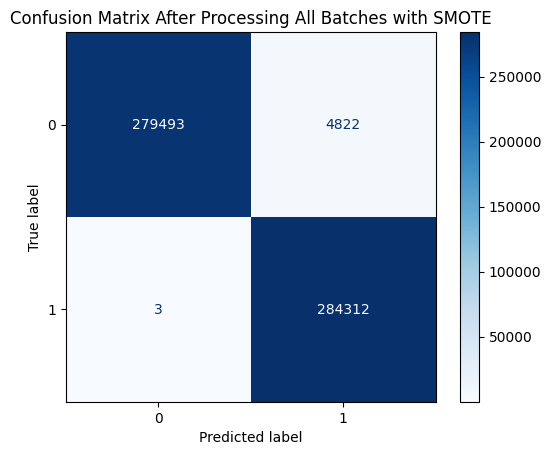

All batches processed with SMOTE.


In [232]:
session.default_fetch_size = 50000  # Fetch 50,000 rows per batch

# Define the query
query = "SELECT id, time, amount, features, label FROM transactions;"
result_set = session.execute(query)
rows = result_set.current_rows

# Prepare the columns
columns = ['id', 'time', 'amount'] + [f'v{i+1}' for i in range(28)] + ['label']

# Initialize LightGBM and SMOTE
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,       # Smaller learning rate for more stable training
    'num_leaves': 128,           # Increase leaves to allow more splits
    'max_depth': -1,             # Remove depth restrictions
    'max_bin': 511,              # Increase bins for finer splits
    'scale_pos_weight': len(y_first_batch) / sum(y_first_batch == 1),  # Handle class imbalance
    'random_state': 42,
    'verbosity': -1               # Set verbosity to check training progress
}
smote = SMOTE(random_state=42)
bst = None  # Initialize the LightGBM booster

# Initialize lists to collect predictions and true labels
all_y_true_smote = []
all_y_pred_smote = []

# Batch processing loop
batch_counter = 1

while True:
    # Check if the current batch is empty
    if not rows:
        break

    # Prepare the data for the current batch
    current_batch_data = []
    for row in rows:
        features = [getattr(row.features, f'v{i+1}') for i in range(28)]
        current_batch_data.append([row.id, row.time, row.amount, *features, row.label])

    # Create a DataFrame for the current batch
    df_current_batch = pd.DataFrame(current_batch_data, columns=columns)

    # Prepare features (X) and labels (y) for the current batch
    X_current_batch = df_current_batch.drop(columns=['id', 'time', 'label']).values
    y_current_batch = df_current_batch['label'].values

    # Apply SMOTE to oversample the minority class
    X_resampled, y_resampled = smote.fit_resample(X_current_batch, y_current_batch)

    # Convert the resampled data to a LightGBM dataset
    dtrain_current = lgb.Dataset(X_resampled, label=y_resampled)

    # Update the model using the resampled data
    if bst is None:
        # Train the model on the first batch
        bst = lgb.train(params, dtrain_current, num_boost_round=100)
    else:
        # Continue training with the new batch
        bst = lgb.train(params, dtrain_current, num_boost_round=100, init_model=bst)

    # Evaluate the model on the resampled data
    y_pred_resampled = (bst.predict(X_resampled) > 0.5).astype(int)
    print(f"Classification Report for Batch {batch_counter} ({len(X_resampled)} rows, After SMOTE):")
    print(classification_report(y_resampled, y_pred_resampled))

    # Collect true labels and predictions for all batches
    all_y_true_smote.extend(y_resampled)
    all_y_pred_smote.extend(y_pred_resampled)

    # Increment batch counter
    batch_counter += 1

    # Fetch the next page
    if result_set.has_more_pages:
        result_set = session.execute(query, paging_state=result_set.paging_state)
        rows = result_set.current_rows
    else:
        break

# Compute the confusion matrix after processing all batches
lightgbm_smote_cm = confusion_matrix(all_y_true_smote, all_y_pred_smote)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=lightgbm_smote_cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")  # Customize as needed
plt.title("Confusion Matrix After Processing All Batches with SMOTE")
plt.show()

print("All batches processed with SMOTE.")

# Comparaison

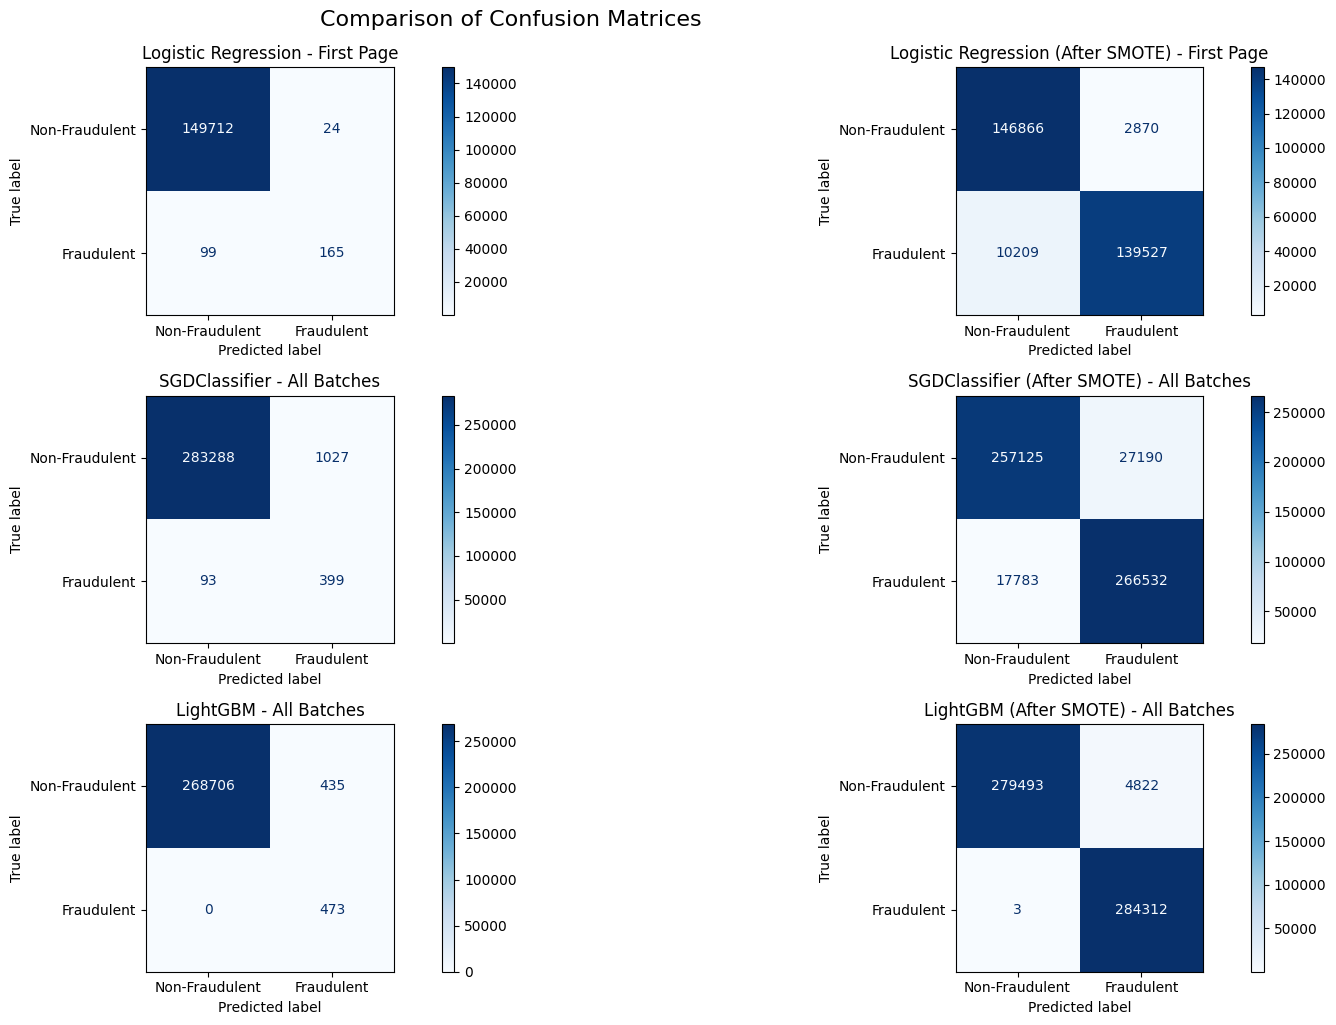

In [234]:
# List of confusion matrices and their titles
confusion_matrices = [
    (logistic_regression_cm, "Logistic Regression - First Page"),
    (smote_logistic_regression_cm, "Logistic Regression (After SMOTE) - First Page"),
    (SGDClassifier_cm, "SGDClassifier - All Batches"),
    (SGDClassifier_smote_cm, "SGDClassifier (After SMOTE) - All Batches"),
    (lightgbm_cm, "LightGBM - All Batches"),
    (lightgbm_smote_cm, "LightGBM (After SMOTE) - All Batches"),
]

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(18, 10))
axes = axes.ravel()

for idx, (cm, title) in enumerate(confusion_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraudulent", "Fraudulent"])
    disp.plot(ax=axes[idx], cmap="Blues", values_format="d")
    axes[idx].set_title(title)

# Adjust layout and show the figure
plt.tight_layout()
plt.suptitle("Comparison of Confusion Matrices", fontsize=16, y=1.02)
plt.show()


### Comparison of Models and Results

1. **Logistic Regression**:
   - **Without SMOTE**: Detects very few fraudulent transactions (165 true positives) but has minimal false positives (24). Poor recall due to class imbalance.
   - **With SMOTE**: Significant improvement in detecting fraud (139,527 true positives), but false positives increase (2,870). Recall improves at the cost of precision.

2. **SGDClassifier**:
   - **Without SMOTE**: Performs moderately with low false positives (1,027) and limited fraud detection (399 true positives).
   - **With SMOTE**: Dramatic improvement in fraud detection (266,532 true positives) but at the expense of increased false positives (27,190). Balances recall and precision better after SMOTE.

3. **LightGBM**:
   - **Without SMOTE**: Excellent performance with no false negatives (473 true positives and 0 false negatives), making it highly reliable for fraud detection. Few false positives (435).
   - **With SMOTE**: Near-perfect performance (284,312 true positives and only 3 false negatives). Slightly more false positives (4,822), but overall precision and recall are outstanding.

### Key Takeaways:
- **SMOTE** improves all models by addressing class imbalance, significantly boosting recall at the cost of precision.
- **LightGBM (With SMOTE)** is the most effective model, achieving the best balance between high recall and low false negatives, making it ideal for fraud detection tasks in highly imbalanced datasets.
